In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [2]:
customers_df = pd.read_csv('customers.csv')
products_df = pd.read_csv('products.csv')
transactions_df = pd.read_csv('transactions.csv')

### Recherche des données manquantes

In [3]:
customers_df.isnull().values.any()

False

In [5]:
products_df.isnull().values.any()

False

In [7]:
transactions_df.isnull().values.any()

False

#### Nous ne remarquons aucune donnée manquante.

### Nettoyage de données

In [9]:
# Jointure externe totale car nous souhaitons garder toutes les informations liées aux 2 dataframes.
tran_prod_df = pd.merge(transactions_df, products_df, on='id_prod', how='outer')

In [10]:
# Jointure externe gauche car nous souhaitons garder toutes les lignes de tran_prod_df
tot_df = pd.merge(tran_prod_df, customers_df, on='client_id', how='left')

In [11]:
# Récupération des Nan selon categ
tp_miss_cat = tot_df[tot_df.categ.isnull() == True]
tp_miss_cat

,id_prod,date,session_id,client_id,price,categ,sex,birth
307991,0_2245,2021-06-17 03:03:12.668129,s_49705,c_1533,NaN,NaN,m,1972.0
307992,0_2245,2021-06-16 05:53:01.627491,s_49323,c_7954,NaN,NaN,m,1973.0
307993,0_2245,2021-11-24 17:35:59.911427,s_124474,c_5120,NaN,NaN,f,1975.0
307994,0_2245,2022-02-28 18:08:49.875709,s_172304,c_4964,NaN,NaN,f,1982.0
307995,0_2245,2021-03-01 00:09:29.301897,s_3,c_580,NaN,NaN,m,1988.0
...,...,...,...,...,...,...,...,...
308089,0_2245,2021-04-06 19:59:19.462288,s_16936,c_4167,NaN,NaN,f,1979.0
308090,0_2245,2021-03-30 23:29:02.347672,s_13738,c_7790,NaN,NaN,f,1983.0
308091,0_2245,2021-12-03 14:14:40.444177,s_128815,c_6189,NaN,NaN,f,1984.0
308092,0_2245,2021-04-27 18:58:47.703374,s_26624,c_1595,NaN,NaN,f,1973.0


#### Un produit unique dont le prix n'a pas été répertorié dans les transactions. Il doit être de catégorie 0 car ce produit commence par '0'. Il s'agit ici de transactions concernant ce produit, nous pourrons remplacer les prix NaN par le prix moyen.

In [12]:
# Remplacement des categ NaN par categ 0 pour tran_prod_df
tot_df['categ'] = tot_df.categ.fillna(0)
# Remplacement des prix NaN par le prix moyen
tot_df['price'] = tot_df.price.fillna(tot_df.price.mean())

In [13]:
# Récupération des NaN selon session_id
tp_miss_ses = tot_df[tot_df.session_id.isnull() == True]

In [14]:
tp_miss_ses

,id_prod,date,session_id,client_id,price,categ,sex,birth
337016,0_1016,NaN,NaN,NaN,35.06,0.0,NaN,NaN
337017,0_1780,NaN,NaN,NaN,1.67,0.0,NaN,NaN
337018,0_1062,NaN,NaN,NaN,20.08,0.0,NaN,NaN
337019,0_1119,NaN,NaN,NaN,2.99,0.0,NaN,NaN
337020,0_1014,NaN,NaN,NaN,1.15,0.0,NaN,NaN
337021,1_0,NaN,NaN,NaN,31.82,1.0,NaN,NaN
337022,0_1318,NaN,NaN,NaN,20.92,0.0,NaN,NaN
337023,0_1800,NaN,NaN,NaN,22.05,0.0,NaN,NaN
337024,0_1645,NaN,NaN,NaN,2.99,0.0,NaN,NaN
337025,0_322,NaN,NaN,NaN,2.99,0.0,NaN,NaN


#### Il s'agit de 22 produits uniques qui n'ont pas été achetés car aucune donnée concernant la date, la session ou encore le client. N'ayant aucun moyen de connaître ces valeurs, il est préférable de supprimer ces 22 lignes de l'analyse.

In [15]:
# Suppression des 22 lignes sus-mentionnées.
tot_df = tot_df.dropna()

In [87]:
a = tot_df[tot_df['id_prod'] == 'T_0']
index_a = a.index
a

,id_prod,date,session_id,client_id,price,categ,sex,birth
226628,T_0,test_2021-03-01 02:30:02.237420,s_0,ct_1,-1.0,0.0,m,2001.0
226629,T_0,test_2021-03-01 02:30:02.237446,s_0,ct_1,-1.0,0.0,m,2001.0
226630,T_0,test_2021-03-01 02:30:02.237414,s_0,ct_1,-1.0,0.0,m,2001.0
226631,T_0,test_2021-03-01 02:30:02.237441,s_0,ct_0,-1.0,0.0,f,2001.0
226632,T_0,test_2021-03-01 02:30:02.237434,s_0,ct_1,-1.0,0.0,m,2001.0
...,...,...,...,...,...,...,...,...
226823,T_0,test_2021-03-01 02:30:02.237445,s_0,ct_0,-1.0,0.0,f,2001.0
226824,T_0,test_2021-03-01 02:30:02.237423,s_0,ct_1,-1.0,0.0,m,2001.0
226825,T_0,test_2021-03-01 02:30:02.237421,s_0,ct_1,-1.0,0.0,m,2001.0
226826,T_0,test_2021-03-01 02:30:02.237431,s_0,ct_1,-1.0,0.0,m,2001.0


#### Il ne s'agit pas d'achat par des clients, mais de transactions test, certainement pour vérifier que les transactions en lignes fonctionnent bien. Nous supprimerons donc ces lignes.

In [17]:
data = tot_df.drop(index_a, 0)

In [18]:
print(data.duplicated().sum())

0


#### Pas de doublons pour notre dataframe final.

### Evolution des ventes au cours du temps.

In [20]:
data['date'] = pd.to_datetime(data.date)

In [21]:
# Somme des transactions par mois
tran_month = data.groupby(pd.Grouper(key='date', freq='M')).price.sum().reset_index()

In [22]:
tran_month_df = pd.DataFrame(tran_month)

In [23]:
tran_month_df['price_k'] = tran_month_df['price'] / 1000

In [24]:
tran_month_df

,date,price,price_k
0,2021-03-31,479466.880592,479.466881
1,2021-04-30,473221.598699,473.221599
2,2021-05-31,489505.594971,489.505595
3,2021-06-30,481378.379350,481.378379
4,2021-07-31,480967.482485,480.967482
5,2021-08-31,479460.040592,479.460041
6,2021-09-30,502977.747456,502.977747
7,2021-10-31,319280.399350,319.280399
8,2021-11-30,513062.226214,513.062226
9,2021-12-31,523058.119350,523.058119


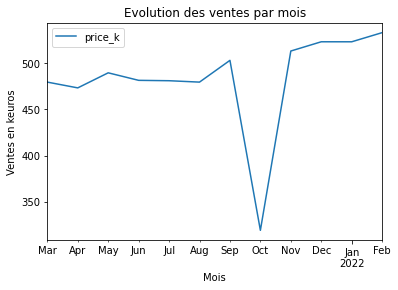

In [25]:
# Visualisation des ventes sur les 12 derniers mois
tran_month_df.plot(x='date', y='price_k')
plt.title('Evolution des ventes par mois')
plt.xlabel('Mois')
plt.ylabel('Ventes en keuros')
plt.savefig("evolution_ventes.png")
plt.show()

#### Nous remarquons une baisse significative des ventes sur le mois d'octobre.

In [26]:
data.categ = data.categ.astype(str)

In [27]:
data['annee-mois'] = data.date.dt.strftime('%Y-%m')

In [28]:
data_g = data.groupby(['annee-mois', 'categ']).id_prod.count()

In [29]:
data_g_df = pd.DataFrame(data_g).reset_index()

In [30]:
data_g0 = data_g_df[(data_g_df['categ'] == '0.0')]
data_g1 = data_g_df[(data_g_df['categ'] == '1.0')]
data_g2 = data_g_df[(data_g_df['categ'] == '2.0')]

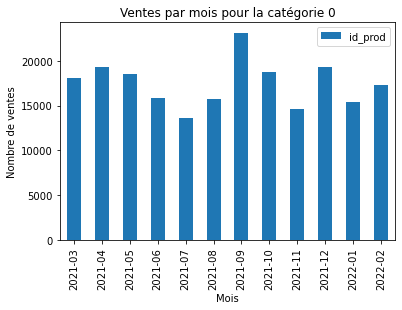

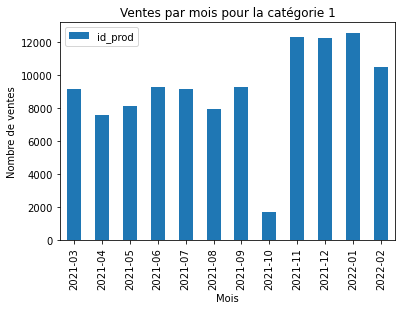

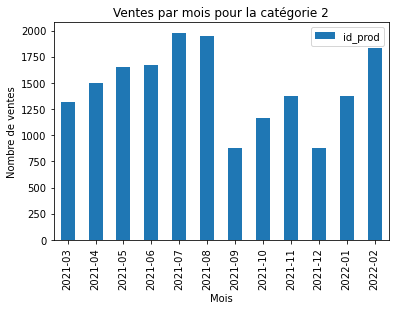

In [31]:
data_g0.plot(kind='bar', x='annee-mois')
plt.title('Ventes par mois pour la catégorie 0')
plt.xlabel('Mois')
plt.ylabel('Nombre de ventes')
plt.savefig("ventes_0.png")

data_g1.plot(kind='bar', x='annee-mois')
plt.title('Ventes par mois pour la catégorie 1')
plt.xlabel('Mois')
plt.ylabel('Nombre de ventes')
plt.savefig("ventes_1.png")

data_g2.plot(kind='bar', x='annee-mois')
plt.title('Ventes par mois pour la catégorie 2')
plt.xlabel('Mois')
plt.ylabel('Nombre de ventes')
plt.savefig("ventes_2.png")

plt.show()

#### Peu de produits de catégorie 1 comptabilisés pour octobre 2021, nous allons voir en détail pourquoi. Hypothese:?

In [32]:
data[(data.date > '2021-10-02') & (data.date < '2021-10-28') & (data.categ == '1.0')].id_prod.count()

0

#### Aucune transaction comptée pour les produits de catégorie 1 entre le 3 et le 27 octobre. Nous supprimerons donc les transactions du mois d'octobre pour la suite de l'analyse.

In [33]:
# Création du dataframe des ventes, le mois d'octobre exclu
data_v1 = data[(data.date <= '2021-09-30') | (data.date >= '2021-11-01')]

data_v1.head()

,id_prod,date,session_id,client_id,price,categ,sex,birth,annee-mois
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,4.99,0.0,f,1977.0,2021-04
2,0_1483,2021-11-14 11:11:45.276771,s_119491,c_182,4.99,0.0,f,1984.0,2021-11
3,0_1483,2021-07-30 19:37:16.087057,s_69222,c_1196,4.99,0.0,m,1980.0,2021-07
4,0_1483,2021-03-30 14:18:13.403218,s_13545,c_2890,4.99,0.0,f,1982.0,2021-03
5,0_1483,2021-05-09 17:45:59.753345,s_32218,c_4690,4.99,0.0,m,1979.0,2021-05


### Analyse des prix

In [34]:
round(data_v1.price.mean(), 2)

17.4

In [35]:
data_v1.price.median()

13.99

In [36]:
data_v1.price.mode()

0    15.99
dtype: float64

In [37]:
round(data_v1.price.var(ddof=0), 2)

319.92

In [38]:
round(data_v1.price.std(ddof=0), 2)

17.89

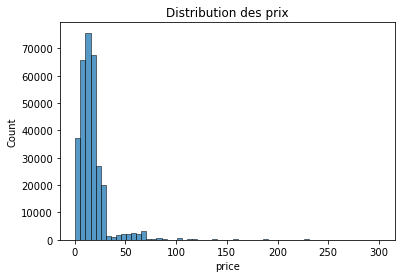

In [39]:
sns.histplot(data=data_v1, x='price', binwidth=5)
plt.title('Distribution des prix')
plt.savefig("distribution_prix.png")
plt.show()

#### Les prix semblent se concentrer autour de la valeur 15, nous le remarquons bien avec les différents indicateurs de tendance centrale. Notamment le mode qui est de 15,99. Cela se confirme grâce à l'histogramme. Nous pouvons déduire que les clients ont tendance à acheter les produits dont la valeur en euros tournent autour de 15 euros.

#### Notons cependant que bien que les ventes se concentrent autour de 15 euros, elles varient énormément, allant même jusqu'à 300 euros. De plus,  les clients achètent pour moins de 40 euros avec une écrasante majorité. Nous allons donc vérifier à quel point les ventes sont réparties.

### Analyse par catégorie

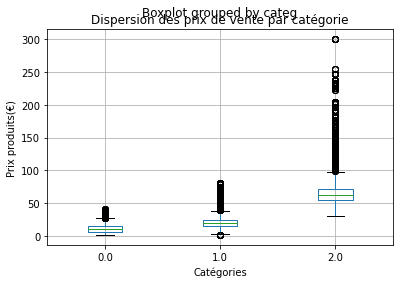

In [40]:
#Comparaison de distribution des prix produits par catégorie avec un boxplot
subset = data_v1[data_v1.price < 1000]
subset.boxplot(column='price', by='categ')

plt.title('Dispersion des prix de vente par catégorie')
plt.xlabel('Catégories')
plt.ylabel('Prix produits(€)')
plt.savefig('prix_categ')

plt.show()

#### Nous constatons ici que les 3 catégories n'ont pas les mêmes gammes de produits. La catégorie 2 a par exemple un prix médian d'environ 60 euros contre environ 25 pour la catégorie 1. Cela explique l'inégalité présente dans la distribution des prix.

In [41]:
effectif = data_v1['categ'].value_counts()
modalite = effectif.index #l'index de 'effectifs' contient les modalités

tab = pd.DataFrame(modalite, columns = ['categ']) #création du tableau à partir des modalités
tab["n"] = effectif.values
tab["f"] = tab["n"] / len(data_v1) 
tab["F"] = tab["f"].cumsum() # cumsum calcule la somme cumulée
tab

,categ,n,f,F
0,0.0,189821,0.604678,0.604678
1,1.0,107727,0.343166,0.947844
2,2.0,16373,0.052156,1.000000


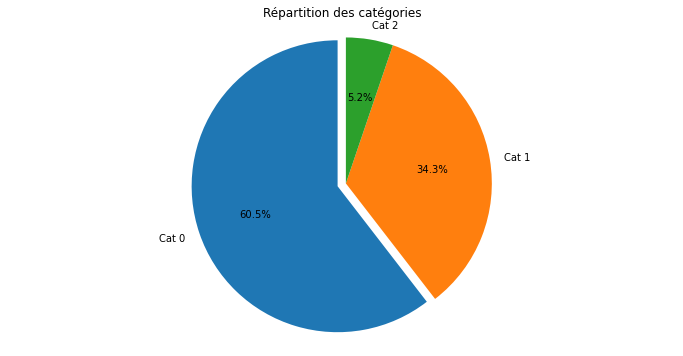

In [42]:
#Pie Chart pour représenter la part de chacune des catégories de vente
labels = 'Cat 0', 'Cat 1', 'Cat 2'
sizes = tab['f']
explode = (0.06, 0, 0)

fig1, ax1 = plt.subplots(figsize=(12,6))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=False, startangle=90)

ax1.axis('equal') 
plt.title('Répartition des catégories')
plt.savefig("repartition_categories.png")
plt.show()

#### Les clients achètent bien plus de produits de catégorie 0, qui représente 60% des ventes contre 34% pour la catégorie 1 et 5% pour la catégorie 2. Cela s'explique en partie aux prix pratiqués selon les catégories, la catégorie 0 ayant la gamme de produit la moins onéreuse.

### Ventes totales par catégorie sur l'année

In [43]:
vtot = data_v1.pivot_table(values='price', index='categ', aggfunc=sum).reset_index()

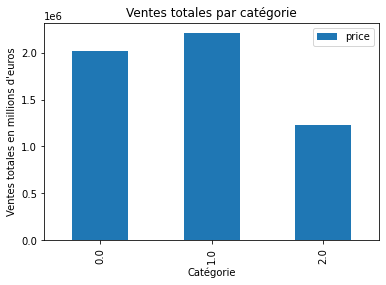

In [44]:
vtot.plot(kind='bar', x='categ')
plt.xlabel('Catégorie')
plt.ylabel("Ventes totales en millions d'euros")
plt.title('Ventes totales par catégorie')
plt.savefig('Ventes_tot')
plt.show()

#### Nous constatons ici un meilleur chiffre d'affaire pour les produits de catégorie 1, talonné par les produits de catégorie 0. Le chiffre d'affaire des produits de catégorie 2, le moins élevé, est expliqué par son faible nombre de produits disponibles et de ventes. Ce qui est en partie compensé par le fait que ces produits sont les plus onéreux.

In [45]:
len(products_df[products_df.categ == 0].groupby('id_prod'))

2309

In [46]:
len(products_df[products_df.categ == 1].groupby('id_prod'))

739

In [47]:
len(products_df[products_df.categ == 2].groupby('id_prod'))

239

#### Nous constatons que les produits de catégorie 0 sont bien plus nombreux que les 2 autres catégories ce qui explique aussi pourquoi la catégorie 0 représente une grande majorité des ventes. Finalement, la proportion des produits par catégorie est cohérente par rapport à la proportion des ventes par catégorie.

### Les livres les plus vendus par catégorie

In [48]:
data_c0 = data_v1[(data_v1['categ'] == '0.0')]
data_c1 = data_v1[(data_v1['categ'] == '1.0')]
data_c2 = data_v1[(data_v1['categ'] == '2.0')]

In [49]:
most_sold0 = data_c0.groupby(['id_prod', 'price']).count()['session_id'].reset_index().sort_values('session_id', ascending=False)
most_sold1 = data_c1.groupby(['id_prod', 'price']).count()['session_id'].reset_index().sort_values('session_id', ascending=False)
most_sold2 = data_c2.groupby(['id_prod', 'price']).count()['session_id'].reset_index().sort_values('session_id', ascending=False)
most_sold0.head(10)

,id_prod,price,session_id
464,0_1422,11.41,607
474,0_1431,10.99,582
467,0_1425,12.99,579
477,0_1434,8.58,567
470,0_1428,3.55,567
452,0_1411,8.99,567
485,0_1441,18.99,565
486,0_1442,4.89,562
466,0_1424,8.41,561
0,0_0,3.75,561


In [50]:
most_sold1.head(10)

,id_prod,price,session_id
299,1_369,23.99,1063
352,1_417,20.99,1042
441,1_498,23.37,1025
349,1_414,23.83,1008
361,1_425,16.99,996
340,1_406,24.81,934
330,1_398,10.17,932
348,1_413,17.99,928
337,1_403,17.99,927
341,1_407,15.99,918


In [51]:
most_sold2.head(10)

,id_prod,price,session_id
41,2_135,68.99,463
5,2_102,59.14,459
16,2_112,67.57,434
170,2_37,48.99,420
14,2_110,62.25,402
172,2_39,57.99,401
122,2_208,54.87,379
123,2_209,69.99,366
121,2_207,50.99,359
177,2_43,69.99,338


#### Nous remarquons ici que malgré le fait que les produits de catégorie 0 soient les plus populaires, les livres les plus vendus appartiennent à la catégorie 1. Cette différence est due en partie au fait qu'il y a 3 fois plus de livres de catégorie 0 disponibles par rapport aux livres de catégorie 1. Les prix de ces livres les plus vendus se concentrent autour de 12 euros pour la catégorie 0, 20 euros pour la catgéorie 1, et 60 euros pour la catégorie 2. De plus, nous constatons bien que les clients ont une préférence pour les produits à moins de 40 euros.

### Analyse des ventes

### Analyse du nombre d'achats par client

In [52]:
fid_client = data_v1.groupby('client_id').count().reset_index()
fid_client['nb_transaction'] = fid_client.session_id
fid_client = fid_client[['client_id', 'nb_transaction']]
fid_client.sort_values(by='nb_transaction', ascending=False).head()

,client_id,nb_transaction
677,c_1609,11794
6336,c_6714,4167
2723,c_3454,3130
4387,c_4958,2452
7790,c_8026,184


In [53]:
#Nombre de client ayant effectué plus d'un achat
fid_client[fid_client['nb_transaction'] > 1].shape[0]

8552

In [54]:
#Nombre de client ayant effectué un seul achat
fid_client[fid_client['nb_transaction'] == 1].shape[0]

46

#### 8552 clients ont donc effetcué au moins 2 achats, nous observons alors une bonne fidélisation des clients qui n'hésitent pas à revenir acheter des produits. En effet, seulement 46 clients n'ont effectué qu'un achat. Obervons maintenant la distribution du nombre d'achat par client.

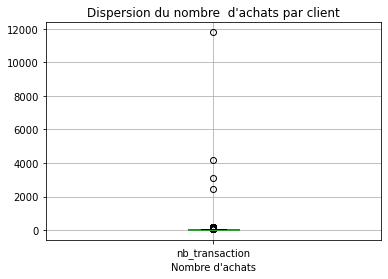

In [55]:
fid_client.boxplot('nb_transaction')
plt.xlabel("Nombre d'achats")
plt.title("Dispersion du nombre  d'achats par client")
plt.savefig("nb_achat_client")
plt.show()

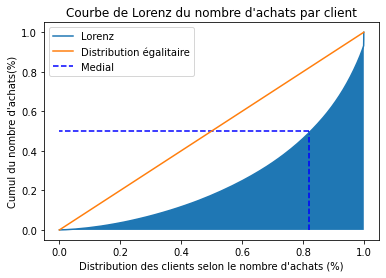

In [56]:
transaction = fid_client['nb_transaction'].values

lorenz_nb = np.cumsum(np.sort(transaction)) / transaction.sum()

plt.plot(np.linspace(0,1,len(lorenz_nb)), lorenz_nb,  label='Lorenz')
plt.fill_between(np.linspace(0,1,len(lorenz_nb)) ,lorenz_nb )
plt.plot([0, 1], [0, 1],  label='Distribution égalitaire')
plt.vlines(x=.82, ymin=0, ymax=.5, color='blue', linestyle='--', label='Medial')
plt.hlines(xmin=.82, xmax=0, y=.5, color='blue', linestyle='--')

plt.title("Courbe de Lorenz du nombre d'achats par client")
plt.xlabel("Distribution des clients selon le nombre d'achats (%)")
plt.ylabel("Cumul du nombre d'achats(%)")
plt.legend()
plt.savefig('lorenz_achat_client')

plt.show()

In [57]:
AUC_1 = lorenz_nb.sum()/len(lorenz_nb) # Surface sous la courbe de Lorenz. Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
S1 = 0.5 - AUC_1 # surface entre la première bissectrice et le courbe de Lorenz
gini_1 = round(2*S1,2)
print(f"L'indice de gini est égal à {gini_1}")

L'indice de gini est égal à 0.49


#### Nous constatons une certaine inégalité de répartition du nombre d'achat par client. En effet, seulement 18% des clients cumulent à eux seuls 50% du nombre total d'achats. Cela se confirme avec l'indice de gini qui est de 0,49. Ce phénomène est notamment expliqué par le fait que 4 clients achètent en masse les livres, certainement pour les revendre. Nous allons maintenant voir ce que cela donne en termes de prix.

In [58]:
achat_client = data_v1.groupby('client_id').price.sum().reset_index()
achat_client.sort_values(by='price', ascending=False).head()

,client_id,price
677,c_1609,150221.600000
4387,c_4958,136786.570000
6336,c_6714,69117.321243
2723,c_3454,52627.221243
7790,c_8026,2441.705621


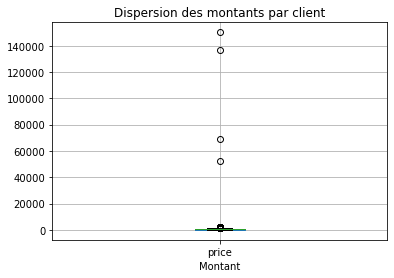

In [59]:
achat_client.boxplot('price')
plt.xlabel('Montant')
plt.title('Dispersion des montants par client')
plt.savefig('montant_client')
plt.show()

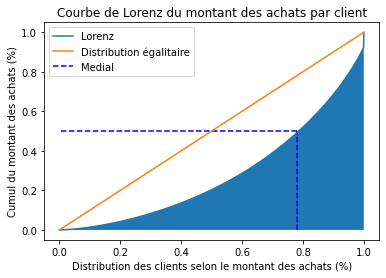

In [60]:
prix = achat_client['price'].values

lorenz = np.cumsum(np.sort(prix)) / prix.sum()

plt.plot(np.linspace(0,1,len(lorenz)), lorenz,  label='Lorenz')
plt.fill_between(np.linspace(0,1,len(lorenz)) ,lorenz)
plt.plot([0, 1], [0, 1],  label='Distribution égalitaire')
plt.vlines(x=.78, ymin=0, ymax=.5, color='blue', linestyle='--', label='Medial')
plt.hlines(xmin=.78, xmax=0, y=.5, color='blue', linestyle='--')

plt.title("Courbe de Lorenz du montant des achats par client")
plt.xlabel("Distribution des clients selon le montant des achats (%)")
plt.ylabel("Cumul du montant des achats (%)")
plt.legend()
plt.savefig('lorenz_montant_client')

plt.show()

In [61]:
AUC_2 = lorenz.sum()/len(lorenz) # Surface sous la courbe de Lorenz. Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
S2 = 0.5 - AUC_2 # surface entre la première bissectrice et le courbe de Lorenz
gini_2 = round(2*S2,2)
print(f"L'indice de gini est égal à {gini_2}")

L'indice de gini est égal à 0.44


#### De même, nous observons relativement la même inégalité de répartition des montants des achats. En effet, 22% des clients cumulent 50% du montant total des achats. Cela se confirme avec l'indice de Gini qui est de 0,44.

#### Finalement, nous remarquons, grâce aux nombres d'achats par clients ainsi que les sommes dépensées par ces mêmes clients, qu'il existe 4 gros clients qui sortent du lot. En effet, leurs sommes dépensées dépassent de très loin celles dépensées par des clients lambda ( au moins 50 000 euros de différences ). Aussi il est utile, pour la suite de l'analyse, de supprimer ces 4 gros clients de l'analyse. Car ils fausseraient les analyses de par leurs montants beaucoup trop élevés.

In [62]:
vip = data_v1[(data_v1['client_id'] == 'c_1609') | (data_v1['client_id'] == 'c_4958') | (data_v1['client_id'] == 'c_6714') | (data_v1['client_id'] == 'c_3454')]
vip_index = vip.index
vip

,id_prod,date,session_id,client_id,price,categ,sex,birth,annee-mois
6,0_1483,2021-09-19 08:45:43.735331,s_92165,c_1609,4.99,0.0,m,1980.0,2021-09
15,0_1483,2021-07-22 20:45:15.286364,s_65805,c_1609,4.99,0.0,m,1980.0,2021-07
16,0_1483,2021-03-31 23:22:23.322344,s_14189,c_6714,4.99,0.0,f,1968.0,2021-03
26,0_1483,2022-02-12 00:32:17.901505,s_163732,c_6714,4.99,0.0,f,1968.0,2022-02
30,0_1483,2021-05-08 06:20:05.395325,s_31519,c_1609,4.99,0.0,m,1980.0,2021-05
...,...,...,...,...,...,...,...,...,...
336994,0_1871,2021-11-01 07:26:17.783922,s_113092,c_1609,1.99,0.0,m,1980.0,2021-11
336998,2_4,2021-03-24 03:00:33.392992,s_10641,c_4958,222.97,2.0,m,1999.0,2021-03
337001,1_470,2021-03-04 09:41:40.700704,s_1550,c_1609,5.41,1.0,m,1980.0,2021-03
337005,0_1191,2021-06-20 12:48:50.925796,s_51304,c_1609,0.99,0.0,m,1980.0,2021-06


In [63]:
data_v2 = data_v1.drop(index=vip_index, axis=0)

### Analyse par âge des clients

In [64]:
data_v2['âge'] = 2022 - data_v2.birth

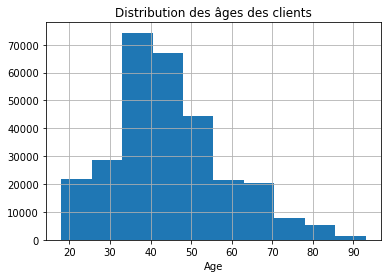

In [65]:
data_v2.âge.hist(bins=10)

plt.xlabel('Age')
plt.title('Distribution des âges des clients')
plt.savefig('distribution_age')

plt.show()

#### Les produits sont achetés en majorité par des clients qui ont entre 32 et 55 ans. 

### Analyse par sexe

In [66]:
data_v2['sex'].value_counts()

f    152296
m    140082
Name: sex, dtype: int64

In [67]:
hf_df = data_v2.pivot_table(index='sex', columns='categ', values='price', aggfunc=sum).reset_index()
hf_df

categ,sex,0.0,1.0,2.0
0,f,977181.607933,1084246.59,566288.29
1,m,907850.359233,978899.42,537722.56


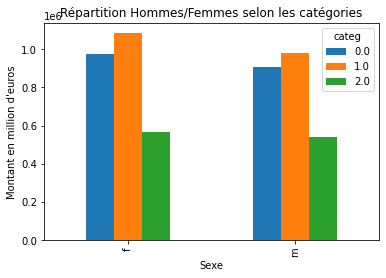

In [68]:
hf_df.plot(kind='bar', x='sex')

plt.title('Répartition Hommes/Femmes selon les catégories')
plt.xlabel('Sexe')
plt.ylabel("Montant en million d'euros")
plt.savefig('sexe_categ')

plt.show()

#### Les femmes dépensent plus que les hommes, d'une légère différence, tant au niveau du nombre d'achats qu'au niveau du montant total par catégorie.

### Corrélation entre le sexe des clients et la catégorie des produits

In [69]:
c = data_v2[['sex', 'categ']].pivot_table(index='sex',columns='categ',aggfunc=len, margins=True, margins_name='Total')
c

categ,0.0,1.0,2.0,Total
sex,,,,
f,91890,52841,7565,152296
m,85075,47890,7117,140082
Total,176965,100731,14682,292378


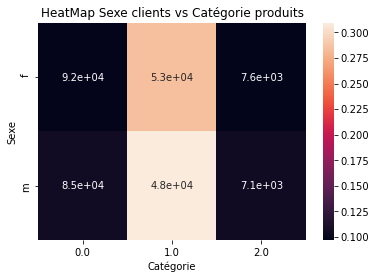

In [70]:
tx = c.loc[:,["Total"]]
ty = c.loc[["Total"],:]
n = len(data_v2)
indep = tx.dot(ty) / n

measure = (c-indep)**2/indep
xi_n = measure.sum().sum()
table = measure/xi_n
sns.heatmap(table.iloc[:-1,:-1],annot=c.iloc[:-1,:-1])
plt.title('HeatMap Sexe clients vs Catégorie produits')
plt.xlabel('Catégorie')
plt.ylabel('Sexe')
plt.savefig('heeatmap_sexe_categ')
plt.show()

In [71]:
cont = data_v2[['sex', 'categ']].pivot_table(index='sex',columns='categ',aggfunc=len)
cont

categ,0.0,1.0,2.0
sex,,,
f,91890,52841,7565
m,85075,47890,7117


In [72]:
chi2, pvalue, degrees, expected = st.chi2_contingency(cont)
chi2, degrees, pvalue

(9.24395840553322, 2, 0.009833314665140036)

#### Le test de Chi2 est utilisé pour tester l'hypothèse nulle (H0) d'absence de relation entre deux variables catégorielles, ce test vérifie donc l'hypothèse d'indépendance de ces variables. La valeur de Chi2 est une quantification de cet écart (entre les occurences attendues et celles observées). Plus la valeur sera élevée, plus l'écart entre l'hypothèse nulle et la situation réelle sera grand. Plus l’occurrence observée est près de l’occurrence attendue, plus la fraction calculée pour chaque cellule est petite et moins l’écart avec H0 est grand.

#### L'indice élevé du Chi2 démontre une importance significative entre les occurences théoriques et celles du tableau de contigence. De plus, la comparaison de p-value (0,98%) avec notre seuil de significativité (5%) expose une valeur inférieure au seuil. L'hypothèse nulle est rejetée en faveur de l’hypothèse alternative, il y a donc une corrélation entre le sexe des clients et les catégories produits, et elle est plûtot forte.

### Corrélation entre l'âge des clients et le montant total des achats

In [73]:
#Nous voulons la somme des montants dépensés par âge.
test = data_v2.groupby('âge')['price'].sum().reset_index()
test

,âge,price
0,18.0,277540.290000
1,19.0,83070.370000
2,20.0,84127.795621
3,21.0,80605.930000
4,22.0,75612.525621
...,...,...
71,89.0,2470.835621
72,90.0,2346.540000
73,91.0,1308.660000
74,92.0,1973.720000


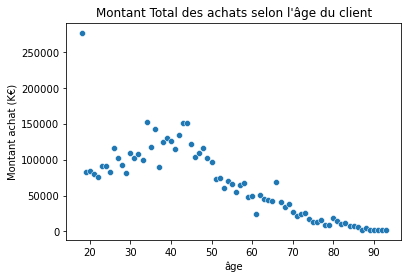

In [74]:
sns.scatterplot(x='âge', y='price', data=test)
plt.xlabel('âge')
plt.ylabel('Montant achat (K€)')
plt.title('Montant Total des achats selon l\'âge du client')

plt.savefig("scatter_montant_achat_age_client")
plt.show()

In [75]:
pd.DataFrame(st.pearsonr(test.âge, test.price), index=['pearson_coeff', 'p-value'], columns=['resultat_test'])

,resultat_test
pearson_coeff,-8.287536e-01
p-value,2.446796e-20


#### Le coefficient est négatif par conséquent, on peut émettre l'hypothèse que plus les consommateurs sont agés plus le montant total de leur achat est faible. Or le coefficient est plus proche de -1 que de zéro. De plus, avec la p-value égal à 2,4e-18%, il y a bien une corrélation entre ces 2 variables. Par conséquent, il y a une corrélation négative entre l'âge des clients et le montant total des achats.

### Correlation entre l'âge des clients et la fréquence d'achat.

In [76]:
#Nous voulons le nombre de transactions par âge, on divise ensuite par le nombre de mois.
test1 = data_v2.groupby('âge')['session_id'].count().reset_index()
test1['session_id'] = round(test1['session_id']/11)
test1

,âge,session_id
0,18.0,632.0
1,19.0,186.0
2,20.0,190.0
3,21.0,176.0
4,22.0,187.0
...,...,...
71,89.0,14.0
72,90.0,13.0
73,91.0,7.0
74,92.0,10.0


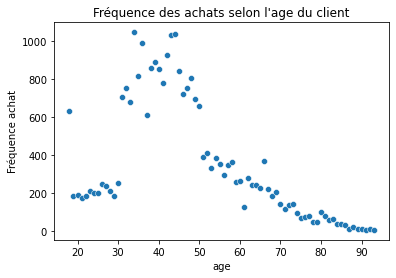

In [77]:
sns.scatterplot(x='âge', y='session_id', data=test1)
plt.xlabel('age')
plt.ylabel('Fréquence achat')
plt.title('Fréquence des achats selon l\'age du client')

plt.savefig("scatter_frequence_achat_age_client")
plt.show()

In [78]:
pd.DataFrame(st.pearsonr(test1.âge, test1['session_id']), index=['pearson_coeff', 'p-value'], columns=['resultat_test'])

,resultat_test
pearson_coeff,-5.733861e-01
p-value,6.174815e-08


####  De même ici, avec la p-value inférieure à 5% et le coefficient de Pearson négatif, nous retrouvons la corrélation négative entre l'âge des clients et leurs fréquences d'achat. Il semblerait que des groupes de clients se formalisent sur cette corrélation, par exemple entre 18 et 30 ans.

### Corrélation entre l'âge des clients et leur panier moyen ( en nombre d'article)

In [79]:
# Nous voulons le nombre de produits par session par âge
test2 = data_v2.groupby(['âge','session_id'])['id_prod'].count().reset_index()
# Pour ensuite avoir la moyenne de ce nombre
test2 = test2.groupby('âge').mean().reset_index()

In [80]:
test2

,âge,id_prod
0,18.0,1.772762
1,19.0,1.734124
2,20.0,1.748744
3,21.0,1.745717
4,22.0,1.843049
...,...,...
71,89.0,1.411215
72,90.0,1.516129
73,91.0,1.772727
74,92.0,1.608696


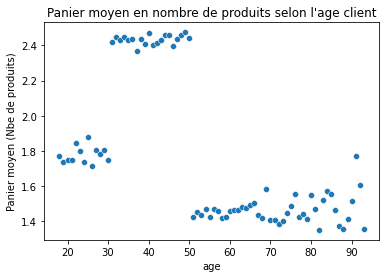

In [81]:
sns.scatterplot(x='âge', y='id_prod', data=test2)
plt.xlabel('age')
plt.ylabel('Panier moyen (Nbe de produits)')
plt.title('Panier moyen en nombre de produits selon l\'age client')


plt.savefig("scatter_panier_moyen_age_client")
plt.show()

In [82]:
pd.DataFrame(st.pearsonr(test2.âge, test2['id_prod']), index=['pearson_coeff', 'p-value'], columns=['resultat_test'])

,resultat_test
pearson_coeff,-5.906288e-01
p-value,1.953600e-08


#### Le test de corrélation démontre une certaine corrélation (coefficient de Pearson égal à 0,59) entre l'âge du client et le panier moyen. Par exemple, sur les individus de plus de 50 ans, le panier moyen reste faible. Il existe également un lien sur les individus de 18 à 30 ans et de 30 à 50 ans. Des corrélations plûtot fortes (coefficient de Pearson égal à -0,59) existent selon les tranches d'âges.

### Corrélation entre l'âge des clients et la catégories des produits

In [83]:
test3 = data_v2.groupby(['âge', 'categ'])['session_id'].count().reset_index()
test3['groupe_age'] = pd.qcut(test3.âge, q=[0, 0.16, 0.43, 0.68,  1])
test3

,âge,categ,session_id,groupe_age
0,18.0,0.0,1527,"(17.999, 30.0]"
1,18.0,1.0,2701,"(17.999, 30.0]"
2,18.0,2.0,2723,"(17.999, 30.0]"
3,19.0,0.0,429,"(17.999, 30.0]"
4,19.0,1.0,800,"(17.999, 30.0]"
...,...,...,...,...
222,92.0,0.0,40,"(69.0, 93.0]"
223,92.0,1.0,70,"(69.0, 93.0]"
224,92.0,2.0,1,"(69.0, 93.0]"
225,93.0,0.0,33,"(69.0, 93.0]"


In [84]:
test3['groupe_age'].unique()

[(17.999, 30.0], (30.0, 50.0], (50.0, 69.0], (69.0, 93.0]]
Categories (4, interval[float64]): [(17.999, 30.0] < (30.0, 50.0] < (50.0, 69.0] < (69.0, 93.0]]

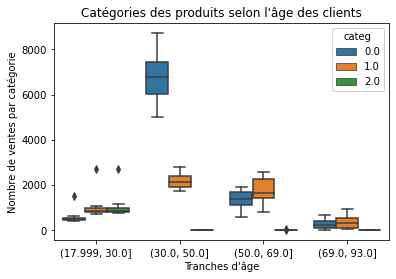

In [85]:
sns.boxplot(x='groupe_age', y='session_id', data=test3, hue='categ')
plt.xlabel("Tranches d'âge")
plt.ylabel("Nombre de ventes par catégorie")
plt.title("Catégories des produits selon l'âge des clients")
plt.savefig("boxplot_age_categ")
plt.show()

In [86]:
anova = smf.ols('session_id~groupe_age', data=test3).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             session_id   R-squared:                       0.324
Model:                            OLS   Adj. R-squared:                  0.315
Method:                 Least Squares   F-statistic:                     35.66
Date:                Fri, 14 Jan 2022   Prob (F-statistic):           7.25e-19
Time:                        03:04:13   Log-Likelihood:                -1993.2
No. Observations:                 227   AIC:                             3994.
Df Residuals:                     223   BIC:                             4008.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                            880.0513    254.321      3.460      0.001     378.871    1381.232
groupe_age[T.Interval(30.0, 50.0, closed='right')]  2142.2821    326.682      6.558      0.000    1498.504    2786.060
groupe_age[T.Interval(50.0, 69.0, closed='right')]   184.2294    330.051      0.558      0.577    -466.188     834.647
groupe_age[T.Interval(69.0, 93.0, closed='right')]  -653.9668    316.555     -2.066      0.040   -1277.790     -30.144
==============================================================================
Omnibus:                       46.620   Durbin-Watson:                   2.838
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              108.502
Skew:                           0.946   Prob(JB):                     2.75e-24
Kurtosis:                       5.810   Cond. No.                         5.69
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Le rapport de corrélation est de 0,324, qui est proche de 0,4 dans le cadre du test par ANOVA, la corrélation est donc significative entre les catégories et l'âge client. Il est perceptible de voir le lien que peut avoir une catégorie en fonction d'une tranche d'âges, avec par exemple un fort succès de la catégorie 0 pour les 30-50 ans, ou à l'inverse une clientèle plus âgée qui n'adhère pas vraiment à cette catégorie, etc..